In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import glob
from PIL import Image
from sklearn import metrics, cross_validation


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Set some parameters
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3
TRAIN_PATH = 'train'
TEST_PATH = 'test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
samples = [file for file in glob.glob('data/images/tmp/*.png')]
masks = [file for file in glob.glob('data/masks/tmp/*.npy')]

In [4]:
print(len(samples))
print(len(masks))

7680
7680


In [5]:
X = np.zeros((len(samples), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for i, id_ in tqdm(enumerate(samples), total=len(samples)):
    X[i] = imread(id_)[:,:,:IMG_CHANNELS]
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = np.load('data/masks/tmp/' + os.path.basename(id_)[:-4] + '.npy')
    mask = np.expand_dims(mask_, axis=-1)
    #imshow(np.squeeze(mask))
    #plt.show()
    Y[i] = mask



Getting and resizing train images and masks ... 


100%|██████████| 7680/7680 [00:07<00:00, 961.98it/s]


In [6]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(y_train))

6144
6144


/usr/lib/python3/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


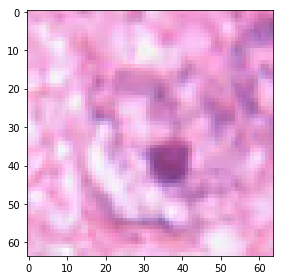

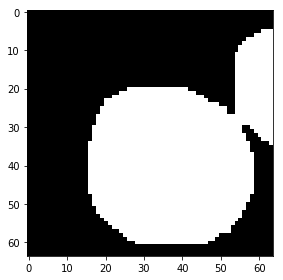

In [67]:
# Check if training data looks all right
ix = random.randint(0, len(X))
imshow(X[ix])
plt.show()
imshow(np.squeeze(Y[ix]))
plt.show()

In [7]:
# Dice coefficient
def dice_coef(y_true, y_pred):
#    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
    intersection = K.sum(y_pred * y_true)
    union = K.sum(y_pred + y_true - y_pred * y_true)
    score = 2 * intersection / (union + intersection)
    K.get_session().run(tf.local_variables_initializer())
    score = tf.identity(score)
    return score

def iou(y_true, y_pred):
    intersection = K.sum(y_pred * y_true)
    union = K.sum(y_pred + y_true) - intersection
    score = intersection / union
    K.get_session().run(tf.local_variables_initializer())
    score = tf.identity(score)
    return score

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def accuracy(y_true, y_pred):
    acc = K.mean(y_pred == y_train)
    K.get_session().run(tf.local_variables_initializer())
    acc = tf.identity(acc)
    return acc

In [12]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(64, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(64, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(128, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(128, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(256, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(256, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(512, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(512, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])

c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])

c7 = Conv2D(256, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(256, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(128, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(64, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   1792        lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [14]:
# Fit model
model = load_model('model-full-bce-64x64-32.h5', custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-full-bce-64x64-32.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=32, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 5529 samples, validate on 615 samples
Epoch 1/30
5529/5529 [==============================] - 27s 5ms/step - loss: 0.1533 - dice_coef: 0.8605 - val_loss: 0.1973 - val_dice_coef: 0.8472

Epoch 00001: val_loss improved from inf to 0.19729, saving model to model-full-bce-64x64-32.h5
Epoch 2/30
5529/5529 [==============================] - 26s 5ms/step - loss: 0.1475 - dice_coef: 0.8659 - val_loss: 0.1873 - val_dice_coef: 0.8632

Epoch 00002: val_loss improved from 0.19729 to 0.18725, saving model to model-full-bce-64x64-32.h5
Epoch 3/30
5529/5529 [==============================] - 26s 5ms/step - loss: 0.1378 - dice_coef: 0.8753 - val_loss: 0.1828 - val_dice_coef: 0.8550

Epoch 00003: val_loss improved from 0.18725 to 0.18279, saving model to model-full-bce-64x64-32.h5
Epoch 4/30
5529/5529 [==============================] - 26s 5ms/step - loss: 0.1327 - dice_coef: 0.8798 - val_loss: 0.1772 - val_dice_coef: 0.8622

Epoch 00004: val_loss improved from 0.18279 to 0.17718, saving model

In [8]:
# Predict on train, val and test
model = load_model('model-full-bce-64x64-32.h5', custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})


In [15]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

1536/1536 [==============================] - 2s 1ms/step


In [16]:
def dice_coef_np(y_pred, y_true):
    intersection = np.sum(y_pred * y_true)
    union = np.sum(y_pred + y_true)
    return 2 * intersection / union

print(dice_coef_np(preds_train_t, y_train[:int(y_train.shape[0]*0.9)]))
print(dice_coef_np(preds_val_t, y_train[int(y_train.shape[0]*0.9):]))
print(dice_coef_np(preds_test_t, y_test))

0.9680138424062952
0.9327276714820305
0.9278367413458742


In [17]:
print(np.mean(preds_train_t == y_train[:int(y_train.shape[0]*0.9)]))
print(np.mean(preds_val_t == y_train[int(y_train.shape[0]*0.9):]))
print(np.mean(preds_test_t == y_test))

0.9787622825386598
0.9534846608231707
0.9510157903035482


In [212]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(preds_test[i])

/usr/lib/python3/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


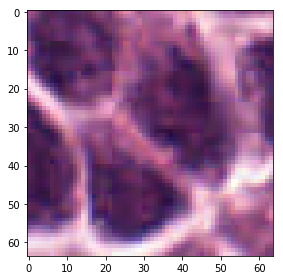

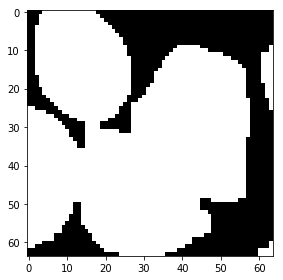

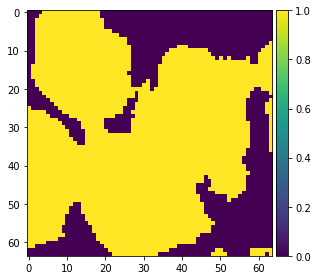

In [19]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
for ix in range(0,len(preds_val_t) -1):
    #imshow(X_train[int(X_train.shape[0]*0.9):][ix])
    #plt.show()
    imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
    plt.show()
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()

In [ ]:
for ix in range(0,len(preds_test_t) -1):
    imshow(np.squeeze(y_test[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t[ix]))
    plt.show()

In [127]:
import imageio
from skimage.util.shape import view_as_windows
train_ids = [x[:-4] for x in os.listdir(TRAIN_PATH + '/images')]
test_ids = [x[:-4] for x in os.listdir(TEST_PATH + '/images')]
print('Splitting training img ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH
    if os.path.isfile(path + '/images/' + id_ + '.tif'):
        img = imread(path + '/images/' + id_ + '.tif')[:,:,:IMG_CHANNELS]
        window_shape = (128, 128,3)
        B = view_as_windows(img[50:950,50:950,:], window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'images','tmp',id_ + "-%s-%s.png" % (i,j))
                imageio.imwrite(tmp_path, B[i,j,0])

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask_ = np.load(path + '/masks/' + id_ + '.npy')
        mask_window_shape = (128, 128)
        C = view_as_windows(mask_, mask_window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'masks','tmp',id_ + "-%s-%s.npy" % (i,j))
                np.save(tmp_path, C[i,j])
        #mask = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
        #                             preserve_range=True), axis=-1)
        #Y_train[n] = mask

Splitting training img ... 


  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2573: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  tile = decompress(tile)
/usr/local/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 26/26 [00:23<00:00,  1.13it/s]


In [128]:

train_ids = [x[:-4] for x in os.listdir(TRAIN_PATH + '/images')]
test_ids = [x[:-4] for x in os.listdir(TEST_PATH + '/images')]
print('Spliting test images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH
    if os.path.isfile(path + '/images/' + id_ + '.tif'):
        
        img = imread(path + '/images/' + id_ + '.tif')[:,:,:IMG_CHANNELS]
        window_shape = (128, 128,3)
        B = view_as_windows(img[50:950,50:950,:], window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'images','tmp',id_ + "-%s-%s.png" % (i,j))
                imageio.imwrite(tmp_path, B[i,j,0])

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask_ = np.load(path + '/masks/' + id_ + '.npy')
        mask_window_shape = (128, 128)
        C = view_as_windows(mask_, mask_window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'masks','tmp',id_ + "-%s-%s.npy" % (i,j))
                np.save(tmp_path, C[i,j])
    #mask = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
    #                             preserve_range=True), axis=-1)
    #Y_train[n] = mask

Spliting test images and masks ... 


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 8/8 [00:05<00:00,  1.58it/s]
